In [324]:
import numpy
import scipy.sparse
import scipy.linalg
from scipy import ndimage
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt

In [325]:
def generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y):
    """Generates a uniform mesh of n_cells_x x n_cells_y on the domain [x_min, x_max] x [y_min, y_max].

    Generates a uniform mesh with n_cells_x x n_cells_y on the domain [x_min, x_max] x [y_min, y_max].
    A (2D) mesh is a collection of (n_cells_x + 1) x (n_cells_y + 1) points (vertices) and a 
    list of n_cells_x x n_cells_y pairs of indices of fours vertices defining the cells.

    The vertices of each cell are given in the following order
    
    3          4
     X ------ X
     |        |
     |        |
     X ------ X
    1          2
 
    The vertex (i, j) of the mesh is given by
        V_{i,j} = [x_min + i delta_x, y_min + j delta_y], i = 0, ..., (n_cells_x + 1), j = 0, ..., (n_cells_y + 1)

    and its single index is given by
        V_{k = i + (n_cells_x + 1)*j} = V_{i, j}

    where
        delta_x = (x_max - x_min)/n_cells_x
        delta_y = (y_max - y_min)/n_cells_y 

    The cell (i, j) of the mesh is given by
        c_{i,j} = [V_{i,j}, V_{i+1, j}, V_{i, j+1}, V_{i+1, j+1}]

    and its single index is given by
        c_{k = i + n_cells_x*j} = c_{i, j}.

    Parameters
    ----------
    x_min : float
        The lower bound of the x interval over which the mesh will be generated.
    x_max : float
        The upper bound of the x interval over which the mesh will be generated.
    y_min : float
        The lower bound of the y interval over which the mesh will be generated.
    y_max : float
        The upper bound of the y interval over which the mesh will be generated.   
    n_cells_x : int
        The number of cells of the mesh in the x-direction.
    n_cells_y : int
        The number of cells of the mesh in the y-direction.

    Returns
    -------
    vertices: numpy.array(float), size [(n_cells_x + 1)*(n_cells_x + 1), 2]
        The x- and y-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x- and y-coordinate of the
        k-th vertex of the mesh, with k given as above V_{k = i + (n_cells_x + 1)*j} = V_{i, j}.
    cells: numpy.array(int), size [n_cells_x * n_cells_x, 4]
        The indices of the four vertices of each cell of the mesh in the order specified above, i.e.,
        cells[k, 0] is the lower left vertex of the k-th cell
        cells[k, 1] is the lower right vertex of the k-th cell
        cells[k, 2] is the upper left vertex of the k-th cell
        cells[k, 3] is the upper right vertex of the k-th cell
        Again, recall the relation between the linear indexing k and the tuple indexing (i,j),
            k = i + n_cells_x * j
    """

    # Make some quantities more clear
    n_vertices_x = n_cells_x + 1
    n_vertices_y = n_cells_y + 1
    n_cells = n_cells_x * n_cells_y

    # Generate the vertices
    x, y = numpy.meshgrid(numpy.linspace(x_min, x_max, n_vertices_x), numpy.linspace(y_min, y_max, n_vertices_y))
    vertices = numpy.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

    # Generate the cells
    cells = numpy.zeros([n_cells, 4], dtype=numpy.int64)
    for j in range(0, n_cells_y):
        for i in range(0, n_cells_x):
            k = i + n_cells_x*j  # the linear cell number
            
            # Now we add the linear index of the vertices of the cell
            # Recall that the vertices of each cell are given in the following order
            #
            #  3          4
            #   X ------ X
            #   |        |
            #   |        |
            #   X ------ X
            #  1          2
            #
            # The vertex (i, j) of the mesh is given by
            # V_{i,j} = [x_min + i delta_x, y_min + j delta_y], i = 0, ..., (n_cells_x + 1), j = 0, ..., (n_cells_y + 1)
            #
            # The cell k = i + n_cells_x(j - 1) of the mesh is given by
            #   c[k, :] = [V_{i,j}, V_{i+1, j}, V_{i, j+1}, V_{i+1, j+1}]
            cells[k, 0] = (i) + (n_cells_x + 1)*(j)  # the linear index of the lower left corner of the element
            cells[k, 1] = (i+1) + (n_cells_x + 1)*(j)  # the linear index of the lower right corner of the element
            cells[k, 2] = (i) + (n_cells_x + 1)*(j+1)  # the linear index of the upper left corner of the element
            cells[k, 3] = (i+1) + (n_cells_x + 1)*(j+1)  # the linear index of the upper right corner of the element

    h_x = (x_max - x_min) / n_cells_x
    h_y = (y_max - y_min) / n_cells_y
    return vertices, cells, h_x, h_y

# Solve 2D Homogeneous Poisson equation

In [326]:
def compute_S_local(u_x, u_y, epsilon, h_x, h_y):
    BIxBK = numpy.array([[-0.5, 0.5], [-0.5, 0.5]])
    BIBK = numpy.array([[0.5, 0.0], [0.0, 0.5]])
    S_1_1 = - u_x * numpy.kron(h_x*BIBK,BIxBK)
    S_1_2 = - u_y * numpy.kron( BIxBK,h_y*BIBK)
    S_1 = S_1_1 + S_1_2
    BIxBKx = numpy.array([[1.0, -1.0], [-1.0, 1.0]])
    S_2 = epsilon * (numpy.kron(1/h_x * (BIxBKx),h_y*(BIBK)) + numpy.kron(h_x*(BIBK), 1/h_y * (BIxBKx)))
    return (S_1 + S_2).T

def compute_S_global(u_x, u_y, epsilon, h_x, h_y, vertices, cells):
    S_global = numpy.zeros([vertices.shape[0], vertices.shape[0]])
    n_cells = cells.shape[0]
    for k in range(0, n_cells):
        cell = cells[k,:]
        S_local = compute_S_local(u_x, u_y, epsilon, h_x, h_y)
        for i in range(0, 4):
            for j in range(0, 4):
                S_global[cell[i], cell[j]] += S_local[i,j]
    
    return S_global

def compute_S_global(u_x, u_y, epsilon, h_x, h_y, vertices, cells):
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    data = []
    i_idx = []
    j_idx = []

    for k in range(n_cells):
        cell = cells[k,:]
        S_local = compute_S_local(u_x, u_y, epsilon, h_x, h_y)
        for i in range(4):
            for j in range(4):
                i_idx.append(cell[i])
                j_idx.append(cell[j])
                data.append(S_local[i,j])

    S_global = csr_matrix((data, (i_idx, j_idx)), shape=(n_vertices, n_vertices))
    return S_global

def compute_forcing_term_2D(f, vertices, cells):
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()
    F = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f(vertices[cell])
        F[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    return F

def set_boundary_conditions(n_cells_x, n_cells_y, S, F, phi_left=0, phi_right=0, phi_bottom=0, phi_top=0):
    # Include the boundary conditions
    # Left boundary
    i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
    j_idx = numpy.arange(0, n_cells_y + 1)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_left

    # Right boundary
    i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
    j_idx = numpy.arange(0, n_cells_y + 1)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_right

    # Bottom boundary
    i_idx = numpy.arange(0, n_cells_x + 1)
    j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:

        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_bottom

    # Top boundary
    i_idx = numpy.arange(0, n_cells_x + 1)
    j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_top
    
    return S, F

def solve_conv_diff_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y, u, epsilon=0.01, solution_choice=0):
                      
    # Setup the right hand side f
    if solution_choice == 0:
        def f(point):
            for i in range(0, len(point[:,0])):
                ret_value = numpy.zeros(len(point[:,0]))
                if point[i,0] < 0.5:
                    ret_value[i] = 1
                else:
                    ret_value[i] = -1
            return ret_value

    # Impose essential (Dirichlet) boundary conditions
    phi_left = 0.0
    phi_right = 0.0
    phi_bottom = 0.0
    phi_top = 0.0

    # Generate the mesh
    vertices, cells, h_x, h_y = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)

    # Setup the global system matrix
    S = compute_S_global(u[0], u[1], epsilon, h_x, h_y, vertices, cells)   # this is not efficient but is to make it explicit (we need the "-"" sign because we performed integration by parts)

    # Compute the right hand side
    F = compute_forcing_term_2D(f, vertices, cells)

    # Include the boundary conditions
    S, F = set_boundary_conditions(n_cells_x, n_cells_y, S, F, phi_left, phi_right, phi_bottom, phi_top)

    # Check if S is a sparse matrix
    if scipy.sparse.issparse(S):
        phi_h = scipy.sparse.linalg.spsolve(S, F)
    else:
        phi_h = scipy.linalg.solve(S, F)

    return vertices, cells, phi_h

def scale_matrix(matrix, target_shape):
    scaled_matrix = ndimage.zoom(matrix, numpy.divide(target_shape, matrix.shape), order=3)
    return scaled_matrix


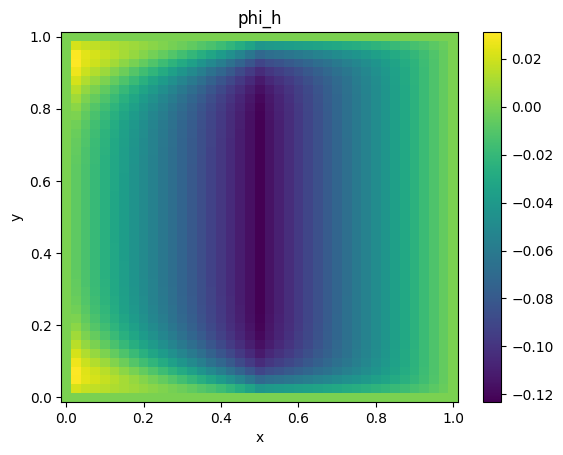

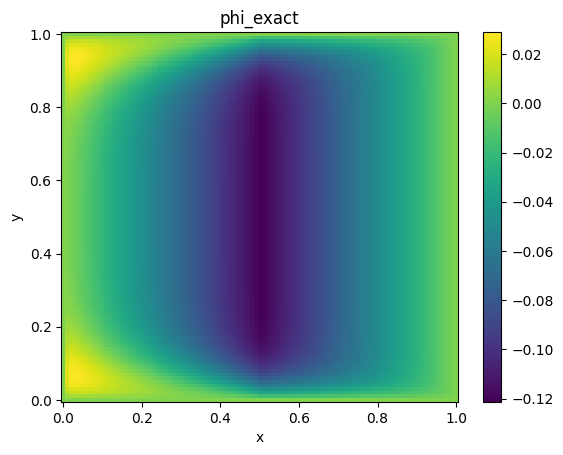

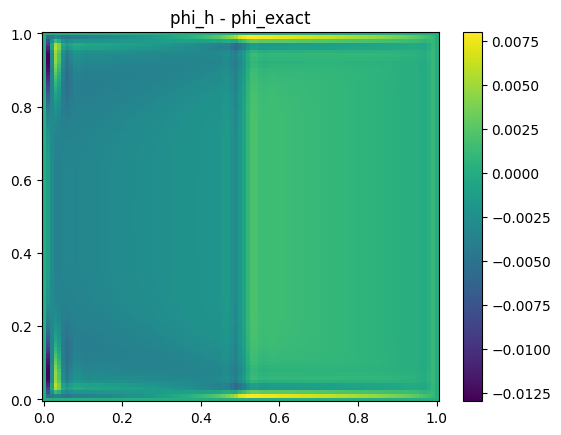

In [329]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0
n_cells_x = 40
n_cells_y = 41
u=[0,1]

vertices, cells, phi_h = solve_conv_diff_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y, u, epsilon=0.01, solution_choice=0)

# Compute the "exact" solution

n_cells_x_ex = 100
n_cells_y_ex = 101

vertices_exact, cells_exact, phi_exact = solve_conv_diff_2D(x_min, x_max, y_min, y_max, n_cells_x_ex, n_cells_y_ex, u, epsilon=0.01, solution_choice=0)

phi_h = phi_h.reshape(n_cells_y+1, n_cells_x+1)
phi_exact = phi_exact.reshape(n_cells_y_ex+1, n_cells_x_ex+1)

phi_h_scaled = scale_matrix(phi_h, phi_exact.shape)

# Check correctness
plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_h)  # plot the error
plt.colorbar()
plt.title("phi_h")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('phi_h.png')  # Save the figure

plt.figure()
plt.pcolormesh(vertices_exact[:, 0].reshape(n_cells_y_ex+1, n_cells_x_ex+1), vertices_exact[:, 1].reshape(n_cells_y_ex+1, n_cells_x_ex+1), phi_exact)  # plot the error
plt.colorbar()
plt.title("phi_exact")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('phi_exact.png')  # Save the figure

plt.figure()
plt.pcolormesh(vertices_exact[:, 0].reshape(n_cells_y_ex+1, n_cells_x_ex+1), vertices_exact[:, 1].reshape(n_cells_y_ex+1, n_cells_x_ex+1), (phi_h_scaled - phi_exact))  # plot the error
plt.colorbar()
plt.title("phi_h - phi_exact")
plt.savefig('phi_h_phi_exact.png')  # Save the figure